In [2]:
#DEPENDENCIES
require(tidyverse)
require(stringr)
require(rstan)
#require(ggpubr)


Loading required package: tidyverse

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.0     v purrr   0.3.3
v tibble  2.1.3     v dplyr   0.8.5
v tidyr   1.0.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: rstan

Loading required package: StanHeaders

rstan (Version 2.19.3, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

For improved execution time, we recommend calling
Sys.setenv(LOCAL_CPPFLAGS = '-march=corei7 -mtune=corei7')
although this causes Stan to throw an error on a few processors.


Attaching package: 'rstan'


The following object is ma

In [3]:
#LOAD IN THE REQUIRED DATA
sim_data_ex = read_rds('RAW_SIM_NUMBER_1_N_SAMPLE_100_FRAC_SIG_0.4_MISSING_RATE_0.3_SIM_DATA.rds')
fit_data_ex = read_rds('RAW_SIM_NUMBER_1_N_SAMPLE_100_FRAC_SIG_0.4_MISSING_RATE_0.3_FIT_DATA.rds')
sum_table_ex = read_csv('RAW_SIM_NUMBER_1_N_SAMPLE_100_FRAC_SIG_0.4_MISSING_RATE_0.3.csv')

Parsed with column specification:
cols(
  label = col_character(),
  tp = col_double(),
  fn = col_double(),
  fp = col_double(),
  tn = col_double(),
  avg_mag_error = col_double(),
  num_sign_error = col_double(),
  n_sig = col_double(),
  n_true = col_double(),
  N_SIM = col_double(),
  N_SAMPLE = col_double(),
  FRAC_SIG = col_double(),
  MISSING_RATE = col_double()
)



In [4]:
#SUMMARY TABLE
sum_table_ex

label,tp,fn,fp,tn,avg_mag_error,num_sign_error,n_sig,n_true,N_SIM,N_SAMPLE,FRAC_SIG,MISSING_RATE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bayes,4,7,0,16,0.7254334,0,4,11,1,100,0.4,0.3
raw,10,1,0,16,1.1962874,0,10,11,1,100,0.4,0.3
bon,3,8,0,16,1.5460570,0,3,11,1,100,0.4,0.3
bh,6,5,0,16,1.4057172,0,6,11,1,100,0.4,0.3


In [5]:
#FIT DATA
names(fit_data_ex)

[1] "sum_table"   "stage_1_fit" "stage_2_fit"

In [6]:
#DEFINE STAGES BASED ON STANFIT OBJECTS
stage_1_fit = fit_data_ex$stage_1_fit
stage_2_fit = fit_data_ex$stage_2_fit

In [7]:
# https://cran.r-project.org/web/packages/rstan/vignettes/stanfit-objects.html

In [8]:
inits = get_inits(stage_2_fit)[[1]]
stage_1_post = extract(stage_1_fit)

In [9]:
names(inits)

[1] "x_impute_raw" "beta_x"       "alpha_x"      "sigma_beta_x" "nu_x"        
[6] "x_impute"

In [10]:
names(stage_1_post)

[1] "beta_impute_raw"     "alpha_impute"        "sigma_impute"       
[4] "sigma_beta_impute_x" "beta_impute"         "x_impute_mean"      
[7] "x_impute"            "lp__"

In [11]:
names(sim_data_ex)

[1] "df_sample"        "truth"            "df_censored"      "df_naive_impute" 
[5] "missing_rates"    "thresholds"       "est.thresholds"   "est.naive_impute"

In [12]:
dim(stage_1_post$x_impute)

[1] 5000 1363

In [13]:
#CALCULATE STAGE 1 MEAN 
imputation_mean = apply(stage_1_post$x_impute, FUN=mean, MARGIN=2)

In [14]:
#CALCULATE STAGE 1 SD
imputation_sd = apply(stage_1_post$x_impute, FUN=sd, MARGIN=2)

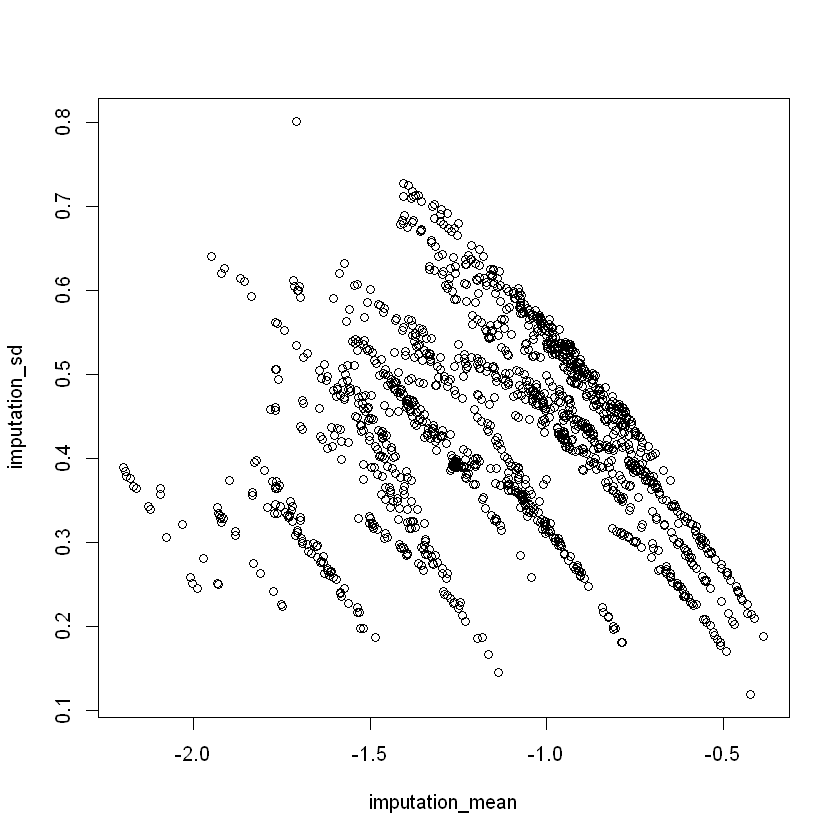

In [15]:
#PLOTS OF STAGE 1 MEAN VS. SD
plot(imputation_mean,imputation_sd)

In [16]:
df_censored = sim_data_ex$df_censored
df_sample = sim_data_ex$df_sample
df_naive_impute = sim_data_ex$df_naive_impute
x_censored = df_censored %>% select(-c(died_90_day))

In [17]:
N_miss = sum(is.na(x_censored))
x_censored = as.matrix(x_censored)
x_missing = matrix(nrow = N_miss, ncol = 2)

# make a table were the first column is the row number in x_censored
# second column contains the metabolite column number in x_censored
col1 = c()
col2 = c()
for(j in 1:dim(x_censored)[2]) {
    missing_in_col = which(is.na(x_censored[,j]))
    col1 = c(col1, missing_in_col)
    col2 = c(col2, rep(j,length(missing_in_col)))
}
x_missing[,1] = col1
x_missing[,2] = col2

In [18]:
x_true = df_sample[ x_missing ]
x_naive_impute = df_naive_impute[ x_missing ]

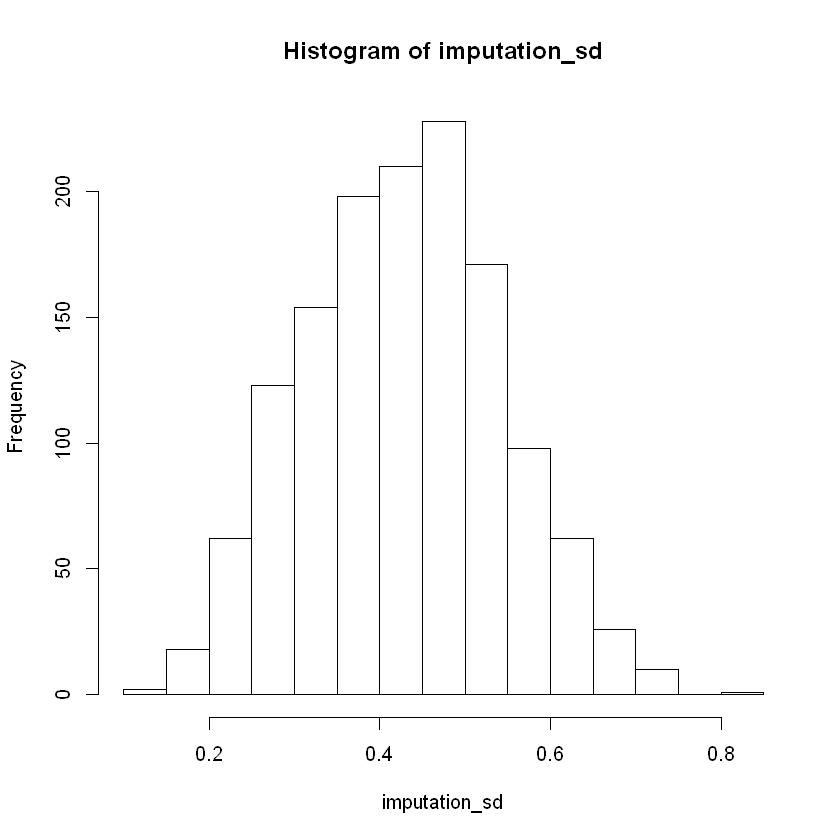

In [19]:
hist(imputation_sd)

In [20]:
weights = 1-imputation_sd/max(imputation_sd)
weights2 = 1/(imputation_sd**2)


In [21]:
#imputation_sd

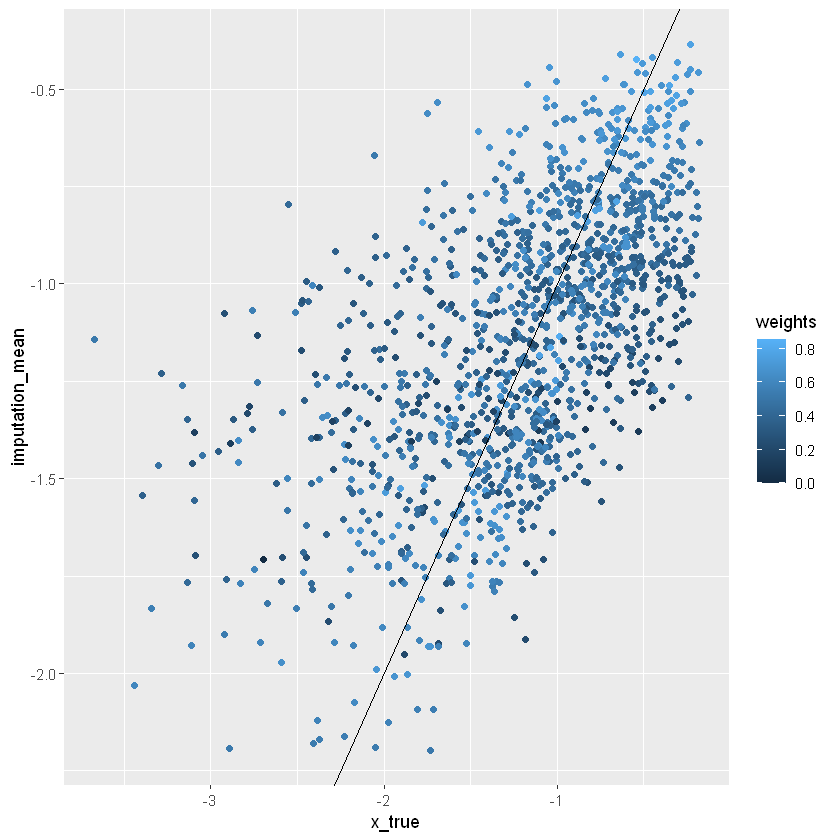

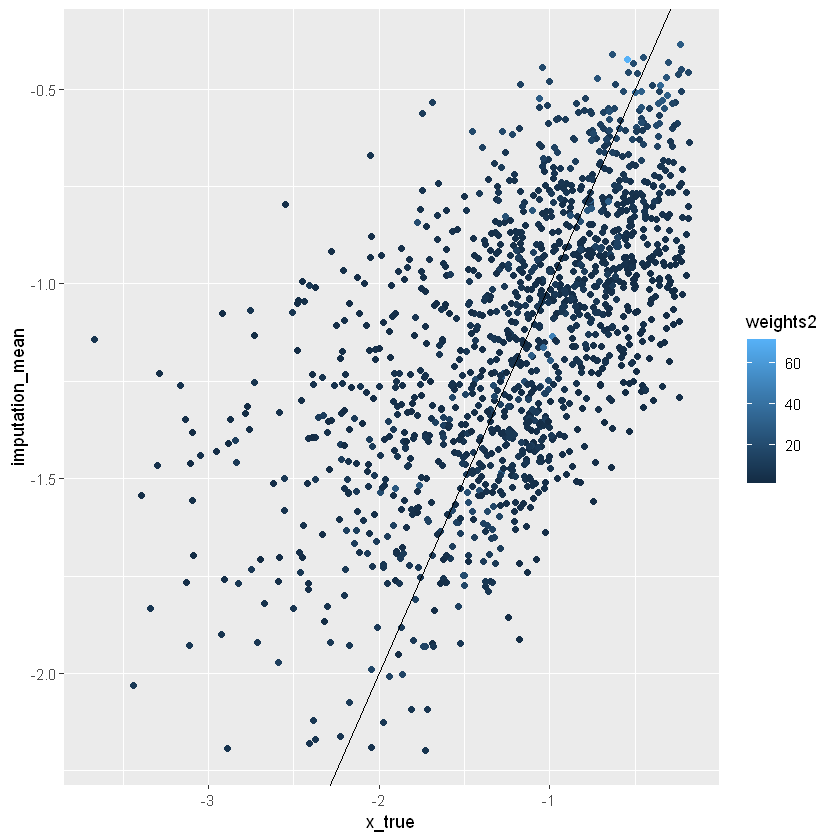

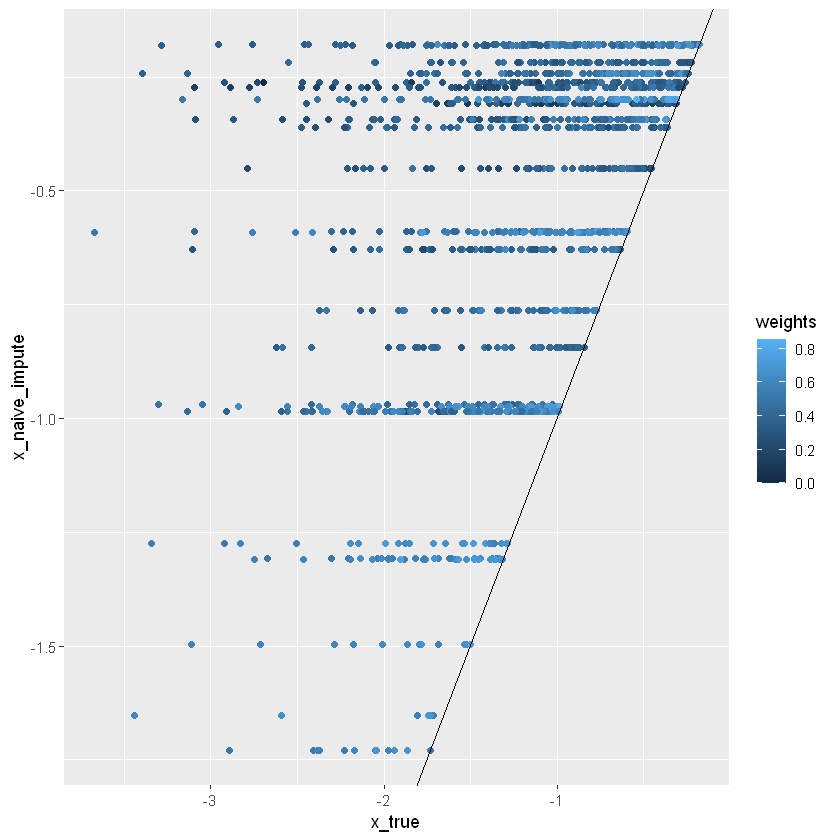

In [22]:
ggplot() + geom_point(aes(x=x_true,y=imputation_mean,color=weights)) + geom_abline(slope=1,intercept=0)

ggplot() + geom_point(aes(x=x_true,y=imputation_mean,color=weights2)) + geom_abline(slope=1,intercept=0)

ggplot() + geom_point(aes(x=x_true,y=x_naive_impute,color=weights)) + geom_abline(slope=1,intercept=0)

#
#

In [23]:
summary( lm(x_true ~ imputation_mean, weights = weights) )


Call:
lm(formula = x_true ~ imputation_mean, weights = weights)

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-1.78035 -0.17202  0.06571  0.24246  0.68870 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.03952    0.04019   0.983    0.326    
imputation_mean  1.07931    0.03428  31.487   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3168 on 1360 degrees of freedom
Multiple R-squared:  0.4216,	Adjusted R-squared:  0.4212 
F-statistic: 991.4 on 1 and 1360 DF,  p-value: < 2.2e-16


In [24]:
summary( lm(x_true ~ imputation_mean, weights = weights2) )


Call:
lm(formula = x_true ~ imputation_mean, weights = weights2)

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-6.3883 -0.6232  0.2381  0.8885  2.2927 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     0.007697   0.034182   0.225    0.822    
imputation_mean 1.051506   0.029656  35.457   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.151 on 1361 degrees of freedom
Multiple R-squared:  0.4802,	Adjusted R-squared:  0.4798 
F-statistic:  1257 on 1 and 1361 DF,  p-value: < 2.2e-16


In [25]:
summary(lm(x_true ~ imputation_mean))


Call:
lm(formula = x_true ~ imputation_mean)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.48634 -0.26220  0.08764  0.34100  1.10668 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.06619    0.04626   1.431    0.153    
imputation_mean  1.09586    0.03902  28.083   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4936 on 1361 degrees of freedom
Multiple R-squared:  0.3669,	Adjusted R-squared:  0.3664 
F-statistic: 788.7 on 1 and 1361 DF,  p-value: < 2.2e-16


In [26]:
summary(lm(x_true ~ x_naive_impute))


Call:
lm(formula = x_true ~ x_naive_impute)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.4396 -0.2739  0.1229  0.4247  0.7285 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -0.77085    0.02635  -29.25   <2e-16 ***
x_naive_impute  0.77899    0.04153   18.76   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.553 on 1361 degrees of freedom
Multiple R-squared:  0.2054,	Adjusted R-squared:  0.2048 
F-statistic: 351.8 on 1 and 1361 DF,  p-value: < 2.2e-16


In [27]:
#r2 from weights 2
sqrt(0.4802)
#r2 from weights 1
sqrt(0.4216)
#r2 from bayes no weights
sqrt(0.3669)
#r2 from naive
sqrt(0.2054)

[1] 0.6929646

[1] 0.6493073

[1] 0.6057227

[1] 0.4532108

* Using the weights (standard deviations) does a better job at imputing the truth
    * 0.65 vs 0.61 correlation
* Naive imputation does much worse
    * 0.65 vs 0.45

In [28]:
#cleaner figures 
#pA = ggplot(df_no_missing %>% filter (FRAC_SIG == frac_sig)) + geom_line(aes(x=N_SAMPLE,y=tpr,color=label))
#pA = pA + theme_classic() + 
  labs(x= "Sample Size per group",
       y= "Power",
       color = "Model") + scale_color_manual(labels = c("Bayes", "Benjamini–Hochberg", "Bonferonni", "Raw"),
                                               values = c("#0072B2", "#D55E00", "#009E73", "#CC79A7"))

#ggplot() + geom_point(aes(x=x_true,y=imputation_mean,color=weights)) + geom_abline(slope=1,intercept=0)

#ggplot() + geom_point(aes(x=x_true,y=x_naive_impute,color=weights)) + geom_abline(slope=1,intercept=0)

                                             
                                    
           

NULL

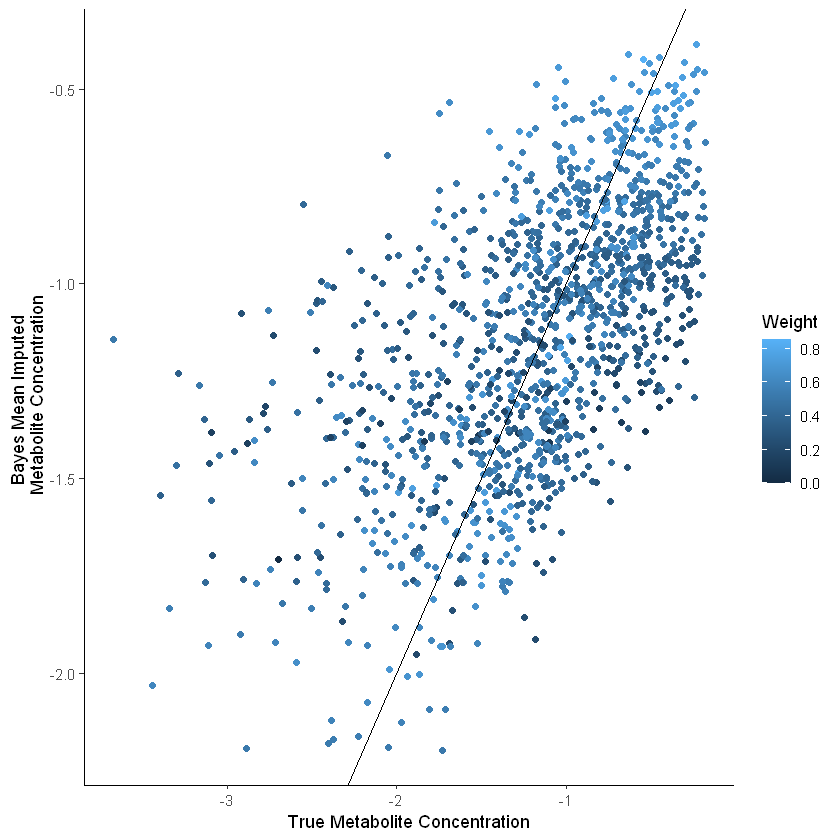

In [29]:
iA = ggplot() + geom_point(aes(x=x_true,y=imputation_mean,color=weights)) + geom_abline(slope=1,intercept=0)
iA = iA + theme_classic() + 
  labs(x= "True Metabolite Concentration",
       y= "Bayes Mean Imputed \n Metabolite Concentration",
       color = "Weight") 
iA

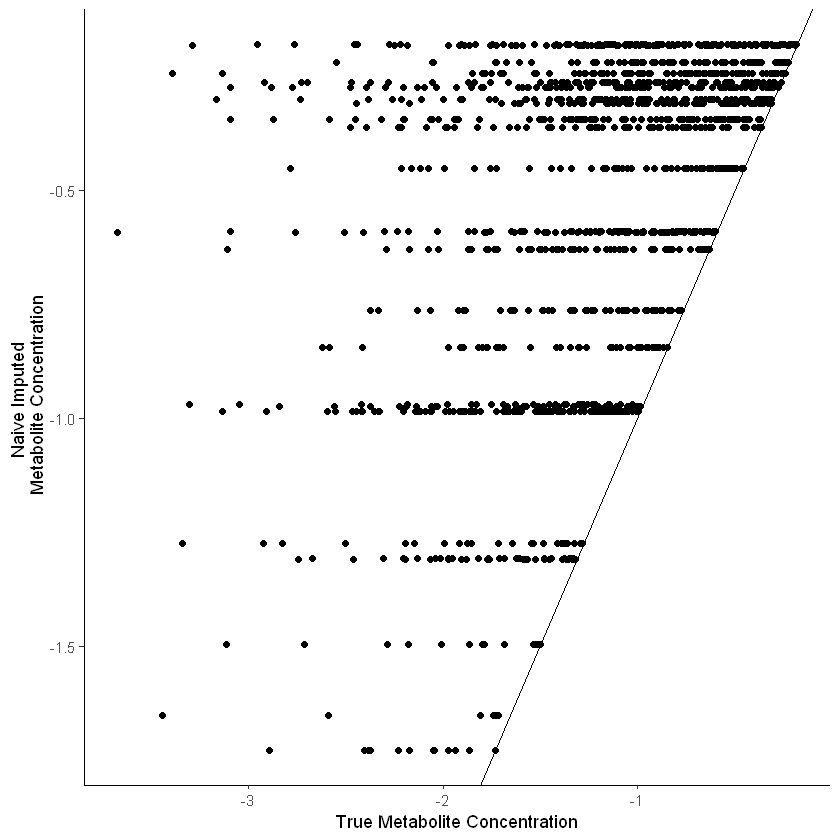

In [33]:
iB = ggplot() + geom_point(aes(x=x_true,y=x_naive_impute)) + geom_abline(slope=1,intercept=0)
iB = iB + theme_classic() + 
    labs(x= "True Metabolite Concentration",
         y= "Naive Imputed \n Metabolite Concentration")
iB

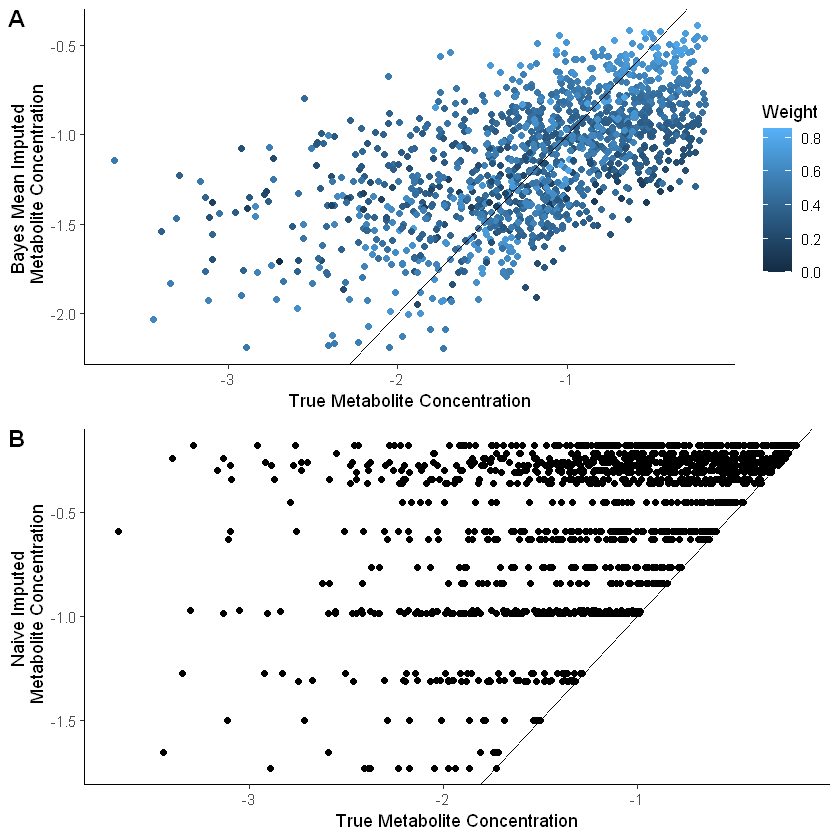

In [34]:
library('ggpubr')
fig_i = ggarrange(iA, iB, labels = c("A", "B"),
          ncol = 1, nrow = 2)
fig_i

In [35]:
ggsave("figure_imp.tiff", plot = last_plot(),scale = 0.85, 
       width = 5, height = 7, units = c("in", "cm", "mm"),
       dpi = 300)